# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (confusion_matrix, classification_report, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             average_precision_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [3]:
#The dataset collected is related to 17 campaigns that
#occurred between May 2008 and November 2010,
#corresponding to a total of 79354 contacts.(YOU CAN FIND IT ---CRISP-DM-BANK.pdf ---)

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
df = pd.read_csv("bank-additional-full.csv", sep=";")
#Why sep=';'?
#The original dataset was saved in European CSV style, where ; 
#is the delimiter (commas are often used as decimal separators there).( I NEEDED TO GOOGLE IT FOR USING';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
# There is no missing value
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [8]:
# 1. Convert categorical variables to pandas categorical type
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 
                   'loan', 'contact', 'month', 'day_of_week', 'poutcome']
                   
for col in categorical_cols:
    df[col] = df[col].astype('category')

# 2. Handle the special value 999 in pdays
# Create a new binary feature indicating if the client was contacted before
df['previously_contacted'] = np.where(df['pdays'] == 999, 0, 1)
# Replace 999 with -1 to better represent 'not contacted before'
df['pdays'] = df['pdays'].replace(999, -1)

# 3. Convert the target variable to binary numeric format
df['y_binary'] = df['y'].map({'yes': 1, 'no': 0})

print('After data preparation:')
print(df.dtypes)

# 4. Summary of 'unknown' values in categorical columns
print('Count of "unknown" values in categorical columns:')
for col in categorical_cols:
    unknown_count = (df[col] == 'unknown').sum()
    if unknown_count > 0:
        print(f'{col}: {unknown_count} ({unknown_count/len(df)*100:.2f}%)')

# Display sample of the prepared data
print('Sample of prepared data:')
print(df[['age', 'job', 'education', 'pdays', 'previously_contacted', 'y', 'y_binary']].head())

# Class distribution of target variable
print('Target variable distribution:')
print(df['y'].value_counts())
print(df['y_binary'].value_counts())

After data preparation:
age                        int64
job                     category
marital                 category
education               category
default                 category
housing                 category
loan                    category
contact                 category
month                   category
day_of_week             category
duration                   int64
campaign                   int64
pdays                      int64
previous                   int64
poutcome                category
emp.var.rate             float64
cons.price.idx           float64
cons.conf.idx            float64
euribor3m                float64
nr.employed              float64
y                         object
previously_contacted       int64
y_binary                   int64
dtype: object
Count of "unknown" values in categorical columns:
job: 330 (0.80%)
marital: 80 (0.19%)
education: 1731 (4.20%)
default: 8597 (20.87%)
housing: 990 (2.40%)
loan: 990 (2.40%)
Sample of prepared data:
   ag

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [8]:
#Business Object is specific goal that we aim to achieve(It usually increase the sales.)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   age                   41188 non-null  int64   
 1   job                   41188 non-null  category
 2   marital               41188 non-null  category
 3   education             41188 non-null  category
 4   default               41188 non-null  category
 5   housing               41188 non-null  category
 6   loan                  41188 non-null  category
 7   contact               41188 non-null  category
 8   month                 41188 non-null  category
 9   day_of_week           41188 non-null  category
 10  duration              41188 non-null  int64   
 11  campaign              41188 non-null  int64   
 12  pdays                 41188 non-null  int64   
 13  previous              41188 non-null  int64   
 14  poutcome              41188 non-null  category
 15  em

In [10]:
#To develop a predictive model that helps the bank identify which clients are most likely to subscribe 
#to a term deposit during a marketing campaign.( Basically data driven model that helps our goal.) 
#This will enable the bank to optimize its telemarketing efforts,
#reduce wasted calls, improve conversion rates, 
#and allocate resources more efficiently in future campaigns.(Make more profits)

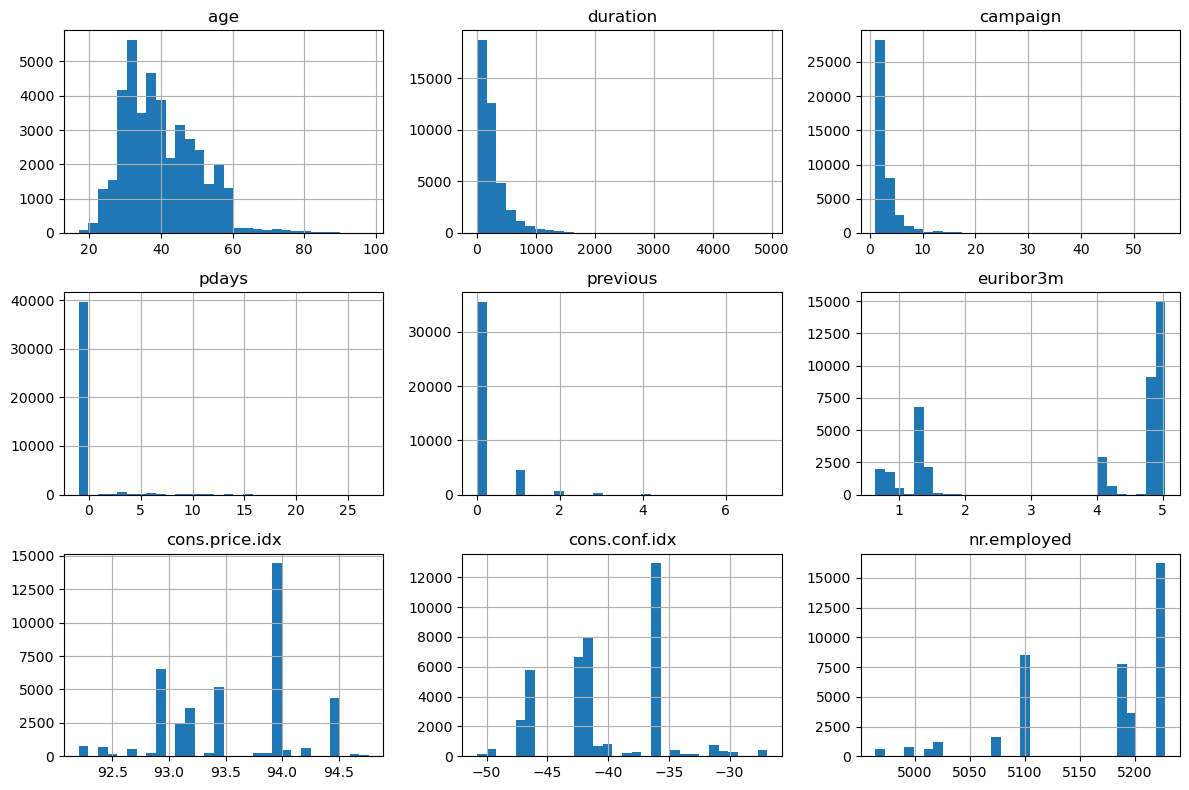

In [10]:
# Numeric histograms (example)
num_cols = ['age','duration','campaign','pdays','previous','euribor3m','cons.price.idx','cons.conf.idx','nr.employed']
df[num_cols].hist(figsize=(12,8), bins=30)
plt.tight_layout()

In [12]:
# WE DID NUMERIC HISTOGRAM BECAUSE;
#We can explore the distribution of multiple numerical variables quickly.
#We can detect patterns like skewness and outliers.
#We will be able to get insights about our data which can help in further data cleaning,
#feature engineering, or choosing appropriate statistical/machine learning models.
#(Good thing we do not have missing values)

In [11]:
display(df['y'].value_counts()) #(We want to see how many 'yes' and how many 'no' are in the dataset.  
display(df['y'].value_counts(normalize=True).mul(100).round(2))  # We can see the percentage.

y
no     36548
yes     4640
Name: count, dtype: int64

y
no     88.73
yes    11.27
Name: proportion, dtype: float64

In [14]:
# Our dataset is highly imbalanced.
#'NO' class is almost 8 times higher than 'YES' class.
#This imbalance can cause problems for many machine learning models 
#because they may learn to just predict the majority class ("no") to get high accuracy
#but fail to correctly identify the minority class ("yes").

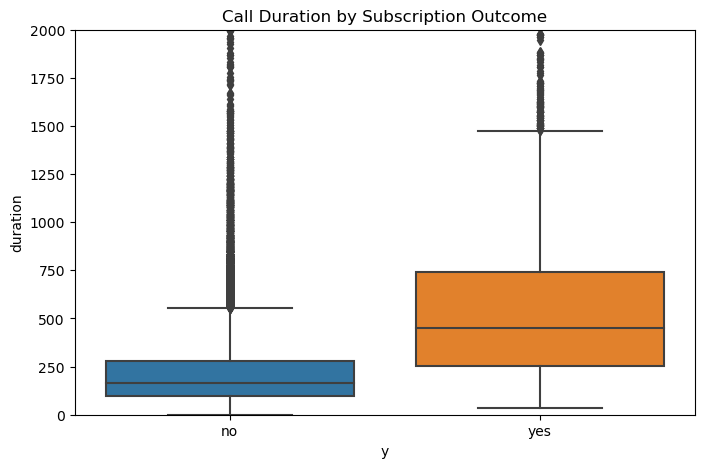

In [12]:
# Boxplot for duration by target
plt.figure(figsize=(8,5))
sns.boxplot(x='y', y='duration', data=df)
plt.title('Call Duration by Subscription Outcome')
plt.ylim(0, 2000)
plt.show()

In [16]:
#We can analyze the distribution of call duration between customers who subscribed (y = yes) and 
#those who did not (y = no).

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [13]:
## feature columns
bank_features = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
                 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
                 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                 'euribor3m', 'nr.employed']

In [14]:
target = 'y'
X = df.drop(columns=[target])
y = df[target].map({'yes': 1, 'no': 0})  # binary encoding target. ML model needs numaerical targets.

# We need to define categorical and numerical columns
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numerical_cols = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# We need turn categorical variables into numbers(encode)
# We should implement scaling for numerical variables for better model performance.

# Pre-processing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])
#Handle_unknown ='ignore' if new categories appear during the transform 
#ignore it encode as zero instead of error.(I just learned that.)
# Fit and transform features
X_encoded = preprocessor.fit_transform(X)

# Now X_encoded is a numeric array ready for modeling.(Ready to go)
# y is our binary target

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [15]:

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,  
    y,          
    test_size=0.2, 
    random_state=42, 
    stratify=y       # Keeps the same class distribution in train and test
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 32950
Testing samples: 8238


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [22]:
# Baseline score means ==>> Score that we need to beat.
#The majority class is “no” (88.73%).
#If we always predict “no” for everyone:
#Accuracy = 88.73% ---#This is our baseline.
#So when we build a real model, it needs to do better than 88.73% accuracy (We should aim to beat 
#and improve recall/precision for the “yes” class — otherwise it can not beat the baseline model.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [16]:
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
log_reg.fit(X_train, y_train)
# Predict probabilities for positive class
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Default threshold 0.5 predictions
y_pred = log_reg.predict(X_test)

print("Classification Report at threshold 0.5:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
#Model all predicted "0" because is imbalanced.

Classification Report at threshold 0.5:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90      7310
           1       0.37      0.65      0.47       928

    accuracy                           0.83      8238
   macro avg       0.66      0.75      0.68      8238
weighted avg       0.88      0.83      0.85      8238

ROC-AUC Score: 0.8008768839332043
Confusion Matrix:
 [[6273 1037]
 [ 329  599]]


In [24]:
#Accuracy = 84% — Our model's accuracy is actually lower than the baseline of always predicting "no" (88.73%). 
#So strictly by accuracy, it doesn't beat the baseline.

#Recall of the positive class (0.65) is pretty decent — it detects 65% of actual positives.

#Precision of the positive class (0.37) is low — many of the predicted positives are false alarms.

#F1-score of the positive class (0.47) shows room for improvement balancing precision and recall.

#Confusion matrix shows many false positives (1029) and false negatives (329)

### Problem 9: Score the Model

What is the accuracy of your model?

In [17]:
y_pred_log = log_reg.predict(X_encoded)
y_pred_prob_log = log_reg.predict_proba(X_encoded)[:, 1]
print(y_pred_prob_log)
print(y_pred_log)

[0.18282818 0.1597286  0.18179405 ... 0.88194752 0.83459998 0.79620374]
[0 0 0 ... 1 1 1]


In [18]:
# Lower threshold to 0.3 for predicting positive class
threshold = 0.3
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
y_pred_lower_thresh = (y_pred_prob >= threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(f"Classification Report at threshold {threshold}:\n", classification_report(y_test, y_pred_lower_thresh))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lower_thresh))

Classification Report at threshold 0.3:
               precision    recall  f1-score   support

           0       0.96      0.44      0.61      7310
           1       0.17      0.87      0.28       928

    accuracy                           0.49      8238
   macro avg       0.56      0.66      0.44      8238
weighted avg       0.87      0.49      0.57      8238

Confusion Matrix:
 [[3249 4061]
 [ 124  804]]


In [27]:
# Accuracy dropped to 49% which is terrible. Lets find the optimum value.
# 0.3 THRESHOLD IS NOT WORTH IT.

Best threshold by F1-score: 0.655
Best F1-score: 0.511


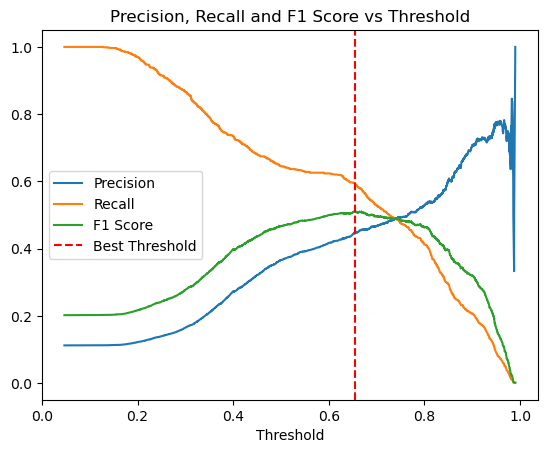

In [19]:
y_scores = log_reg.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Calculate F1 for all thresholds
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold with max F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f'Best threshold by F1-score: {best_threshold:.3f}')
print(f'Best F1-score: {f1_scores[best_idx]:.3f}')

# Plot Precision-Recall curve
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(x=best_threshold, color='r', linestyle='--', label='Best Threshold')
plt.xlabel('Threshold')
plt.legend()
plt.title('Precision, Recall and F1 Score vs Threshold')
plt.show()

In [29]:
# BEST THRESHOLD IS 0.668

In [20]:
best_threshold = 0.668

y_pred_best_thresh = (y_pred_prob >= best_threshold).astype(int)

from sklearn.metrics import classification_report, confusion_matrix

print(f"Classification Report at threshold {best_threshold:.3f}:\n", classification_report(y_test, y_pred_best_thresh))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_thresh))

Classification Report at threshold 0.668:
               precision    recall  f1-score   support

           0       0.94      0.91      0.93      7310
           1       0.46      0.58      0.51       928

    accuracy                           0.87      8238
   macro avg       0.70      0.75      0.72      8238
weighted avg       0.89      0.87      0.88      8238

Confusion Matrix:
 [[6671  639]
 [ 391  537]]


In [32]:
#Accuracy = 87%, which is just under our baseline (88.73%) — close though! BUBT STILL COULD NOT BEAT THE BASELINE.



### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [23]:
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [ ]:
# I MADE A MISTAKE I RUN ALL 3 MODELS WITHOUT SCALING AND THIS CAUSED EXTRAORDINARY CPU Usage

In [ ]:
# Lets Scale first.

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
# Logistic Regression
start = time.time()
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
log_reg_train_time = time.time() - start
log_reg_train_acc = accuracy_score(y_train, log_reg.predict(X_train_scaled))
log_reg_test_acc = accuracy_score(y_test, log_reg.predict(X_test_scaled))

In [26]:
# KNN
start = time.time()
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
knn_train_time = time.time() - start

knn_train_acc = accuracy_score(y_train, knn.predict(X_train_scaled))
knn_test_acc = accuracy_score(y_test, knn.predict(X_test_scaled))

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


In [27]:
# SVM (use linear kernel for speed)
start = time.time()
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_scaled, y_train)
svm_train_time = time.time() - start

svm_train_acc = accuracy_score(y_train, svm.predict(X_train_scaled))
svm_test_acc = accuracy_score(y_test, svm.predict(X_test_scaled))

In [28]:
# Decision Tree
start = time.time()
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
dt_train_time = time.time() - start

dt_train_acc = accuracy_score(y_train, dt.predict(X_train))
dt_test_acc = accuracy_score(y_test, dt.predict(X_test))

In [30]:
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM'],
    'Train Time (s)': [round(log_reg_train_time, 4), round(knn_train_time, 4), round(dt_train_time, 4), round(svm_train_time, 4)],
    'Train Accuracy': [round(log_reg_train_acc, 4), round(knn_train_acc, 4), round(dt_train_acc, 4), round(svm_train_acc, 4)],
    'Test Accuracy': [round(log_reg_test_acc, 4), round(knn_test_acc, 4), round(dt_test_acc, 4), round(svm_test_acc, 4)]
})

print(results_df)

                 Model  Train Time (s)  Train Accuracy  Test Accuracy
0  Logistic Regression         49.0464          0.8785         0.8809
1                  KNN          0.0046          0.9221         0.8863
2        Decision Tree          0.8679          0.9029         0.9025
3                  SVM        575.6528          0.8973         0.8978


In [ ]:
#Among the four models, KNN achieved the highest training accuracy (92.21%) with a very short training time (0.0046 seconds),
#and its test accuracy (88.63%) was slightly higher than Logistic Regression.
# Decision Tree delivered balanced performance with strong accuracy on both training (90.29%) and
#testing (90.25%) while keeping training time under a second. Logistic Regression performed consistently
#with 87.85% training and 88.09% testing accuracy but required a longer training time (49.05 seconds).
#SVM showed good accuracy (around 89%) but had the slowest training process by far (over 575 seconds),
#making it less efficient compared to the others despite its stable results.

In [ ]:
##THIS IS AI JUST WANTED TO COMPARE WITH MINE
##WHAT I BELIEVE IS MY CODE IS CLEANER AND EASY TO UNDERSTAND.
#models = {
 #   'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
  #  'KNN': KNeighborsClassifier(),
   # 'Decision Tree': DecisionTreeClassifier(random_state=42),
    #'SVM': SVC(random_state=42)
#}

#results = []

#for model_name, model in models.items():
 #   start_time = time.time()
  #  model.fit(X_train, y_train)
   # train_time = time.time() - start_time
    
    #y_train_pred = model.predict(X_train)
    #y_test_pred = model.predict(X_test)
    
    #train_acc = accuracy_score(y_train, y_train_pred)
    #test_acc = accuracy_score(y_test, y_test_pred)
    
    #results.append({
     #   'Model': model_name,
      #  'Train Time (s)': round(train_time, 4),
       # 'Train Accuracy': round(train_acc, 4),
        #'Test Accuracy': round(test_acc, 4)
    #})

## Convert results to DataFrame for nice display
#results_df = pd.DataFrame(results)
#print(results_df)(This is AI JUST WANTED TO COMPARE WITH MINE.)

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [33]:
#WE DO NOT HAVE 'GENDER' COLUMN.

In [34]:
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=42)


In [35]:
# Define hyperparameter grids
knn_params = {'n_neighbors': [3,5,7,9], 'weights': ['uniform', 'distance']}
dt_params = {'max_depth': [None, 5, 10, 15], 'min_samples_leaf': [1, 2, 4]}

In [36]:
# Grid search for KNN
knn_grid = GridSearchCV(knn, knn_params, cv=3, scoring='f1', n_jobs=-1)
knn_grid.fit(X_train, y_train)
knn_best = knn_grid.best_estimator_

In [37]:
# Grid search for Decision Tree
dt_grid = GridSearchCV(dt, dt_params, cv=3, scoring='f1', n_jobs=-1)
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [40]:
for model_name, model in [('KNN', knn_best), ('Decision Tree', dt_best)]:
    y_pred = model.predict(X_test)
    print(f"\n{model_name} best params: {model.get_params()}")
    print(f"{model_name} Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"{model_name} Test Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"{model_name} Test Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"{model_name} Test F1 Score: {f1_score(y_test, y_pred):.4f}")


KNN best params: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
KNN Test Accuracy: 0.8980
KNN Test Precision: 0.5940
KNN Test Recall: 0.2996
KNN Test F1 Score: 0.3983

Decision Tree best params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Decision Tree Test Accuracy: 0.9025
Decision Tree Test Precision: 0.6801
Decision Tree Test Recall: 0.2543
Decision Tree Test F1 Score: 0.3702


In [42]:
#Both KNN and Decision Tree achieve around 90% accuracy,
#but this can be deceptive if the dataset is imbalanced. 
#KNN shows reasonable precision (59%) but low recall (30%), missing many actual positive cases. 
#The Decision Tree improves precision (68%) but has even lower recall (25%), 
#indicating it predicts positives more cautiously but identifies fewer true positives. 
#The relatively low F1 scores (around 37-40%) highlight a challenge in balancing precision and recall. 
#To enhance performance, strategies to boost recall—such as adjusting classification thresholds
#or applying data balancing methods—should be considered.


##### Questions